In [1]:
from migraine import *
from migraine_data import *

In [2]:
settings = {
    'app_id': 'my_web_app',
    'api_base': 'http://api-v5-stu3.hspconsortium.org/MigrainApp/open'
}
smart = client.FHIRClient(settings=settings)


## Users

In our demo scenario, we have two app users:
- **Julie Margaret Doe**: A 13-year-old girl who suffers from migraines. Her clinician wants her to be engaged in her care, as well as to to understand how her migraines vary over time and what kind of triggers cause them. To do that, she'll be using our app to track when she has headaches, how severe they are, and what caused them.


In [3]:
patient = get_user('Julie Margaret Doe', usertype='patient', 
         server=smart.server)
display_user(patient)

PATIENT
----------------------
Name: Julie Margaret Doe
Gender: female
DOB: 2005-05-04 00:00:00
Address: 123 Some Place Salt Lake City UT 84103


- **Jane Doe**: Julie's mother. Jane wants to be involved in Julie's care and wants to participate in tracking her migraines. This is especially helpful when Julie is in too much pain to log onto her computer during a headache and log the headache info.

In [4]:
care_partner = get_user('Jane Doe', usertype='care partner',
                       server=smart.server)
display_user(care_partner)

CARE PARTNER
----------------------
Name: Jane Doe
Gender: female
DOB: 1975-07-06 00:00:00
Address: 123 Some Place Salt Lake City UT 84103
Relationship: Mother to [Julie Margaret Doe]


# App Feature #1: Adding Headache Info

We wrote a front-end interface using Angular that allows a user to enter information about their headache into a form. This data will then be added to a local database and later pushed to the remote server (EHR).

[Add New Headache](http://localhost:4200/)

# App Feature #2: Viewing Headache Info
In addition to allowing the users to track headache data and send it to the provider, our app will also present this data back to the user in a way that can help them understand how the patient's problems have changed over time.

The first variable we track is the pain severities of headaches.

In [5]:
pain_levels = get_pain_levels('Julie Margaret Doe', server=smart.server)
display_pain_levels(pain_levels)

00-01-2018: 2/10
00-01-2018: 3/10
00-03-2018: 0/10
00-04-2018: 4/10
00-04-2018: 7/10
00-06-2018: 5/10
00-06-2018: 2/10
00-06-2018: 6/10
00-06-2018: 8/10
00-06-2018: 10/10


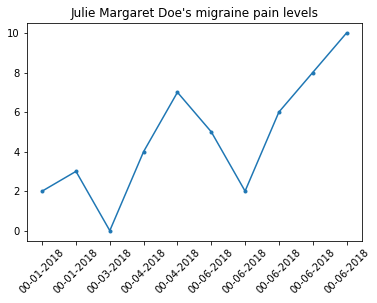

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_pain_levels('Julie Margaret Doe', server=smart.server)

# App Feature #3: View Headache Triggers

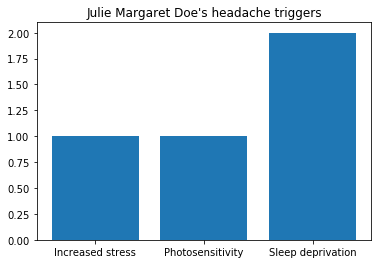

In [7]:
plot_triggers('Julie Margaret Doe', smart.server)

# App Feature #4: Viewing Active Medications

In [8]:
meds = get_active_medications(patient_name='Julie Margaret Doe', server=smart.server)

In [9]:
display_medication_list(patient_name='Julie Margaret Doe', server=smart.server)

1.  Amitriptyline hydrochloride 50 mg oral tablet - 1 TAB PO DAILY
2.  Divalproex sodium 250mg tablet delayed release - 1 TAB PO TWICE DAILY
3.  Ibuprofen 200 mg oral tablet - 1 TAB PO THREE TIMES PER WEEK
4.  Metoclopramide hydrochloride 10 mg oral tablet - 1 TAB PO BID
5.  Riboflavin - 200mg PO DAILY
6.  Sumatriptan 50 mg oral tablet - 1 TAB PO THREE TIMES PER WEEK
7.  Ubidecarenone - 200 mg PO THREE TIMES PER WEEK


# App Feature #5: Take user input and convert into FHIR Resources

We model our entries as FHIR List resources. So we'll take a JSON object that was generated by the front-end and convert it into a List resource that could then be pushed to a server.

In [10]:
import json
with open('entry.json') as f:
    entry = json.load(f)
entry

{'author': 'Jane Doe',
 'date': '2018-02-8',
 'entries': {'comments': 'Julie was in a lot of pain today.',
  'headache': [{'date': '2018-08-07', 'severity': '6', 'time': '22:06'}],
  'medications': [{'date': '2018-02-6',
    'idx': '0',
    'name': 'Ibuprofen 200mg',
    'time': '10:06'}],
  'triggers': [{'date': '2018-02-8',
    'idx': '0',
    'name': 'Sleep deprivation',
    'time': '10:06'},
   {'date': '2018-02-06',
    'idx': '1',
    'name': 'Photosensitivity',
    'time': '10:07'}]},
 'id': 'Entry-1',
 'time': '10:06'}

Using this oject, we can now create new resources. We'll create one resource for each part of the 'entries' field (except for medications, that's up next), as well as one FHIR List to link them all together. 

In [11]:
new_resources = create_fhir_list(entry)
new_resources

In [12]:
# Here's a look at what the List resource looks like
new_resources[-1].as_json()

{'date': '2018-02-8T10:06:00.000Z',
 'entry': [{'item': {'reference': 'Condition/cf-9493'}},
  {'item': {'reference': 'Observation/cf-911877'}},
  {'item': {'reference': 'Condition/cf-1273'}},
  {'item': {'reference': 'Condition/cf-4428'}}],
 'id': 'cf-487055',
 'identifier': [{'value': 'List-9969'}],
 'meta': {'lastUpdated': '2018-02-8T10:06:00.000Z', 'versionId': '1'},
 'mode': 'snapshot',
 'resourceType': 'List',
 'status': 'current',
 'text': {'div': '<div xmlns="http://www.w3.org/1999/xhtml"><a name="mm"></a></div>',
  'status': 'generated'}}

# Next Steps
- **Connect front-end to back-end.** Currently, the input form doesn't really do anything with the data that the user inputs. Eventually we'll need to be able to post from the front-end Angular app to the back-end Django app and save this data to the local database.
- **Push to the remote server.** We've shown that we can take data that exists on some remote server (ie., an EHR). Next, we need to do the reverse: take FHIR resources that we've generated from user input and push it to the server.